In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json

import time
import numpy as np
from random import shuffle

In [2]:
import inspect
import math

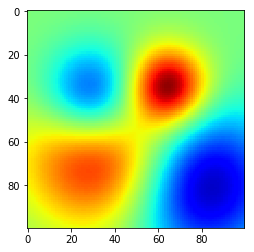

In [3]:
# generate a toy 2D regression dataset
sz = 100
X,Y = np.meshgrid(np.linspace(-1,1,sz),np.linspace(-1,1,sz))
mux,muy,sigma=0.3,-0.3,4
G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=-0.3,0.3,2
G2 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=0.6,0.6,2
G3 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=-0.4,-0.2,3
G4 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
G = G1 + G2 - G3 - G4
fig,ax = plt.subplots()
im = ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
#plt.axis('off')

In [4]:
class saddle_space:
    def __init__(self):
        self.dim = 2
    
    def fitness(self,x):
        return [G[int(x[0]),int(x[1])]]
    
    def get_bounds(self):
        return ([0,0],[99,99])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
        x,y = zip(*w)
        plt.scatter(x,y,4,'k',edgecolors='face')
        plt.scatter(w[idx][0],w[idx][1],15,'y',edgecolors='k')

In [5]:
class salimans_nes:
    def __init__(self,iter=12):
        super(salimans_nes,self).__init__()
        self.prevx,self.prevy = [],[]
        
        self.iter=iter # number of steps towards estimated gradient
    
    def evolve(self,pop):
        if len(pop) == 0:
            return pop
        sigma = 3
        alpha = 0.03 # learningrate
        
        # plotting
        plotting = False
        if plotting:
            plt.figure(figsize=(self.iter,self.iter))
            no_rows = int(self.iter/4+1)
            gs = gridspec.GridSpec(no_rows,4)
            plot_index = 0
        
        #for each iteration, jitter around starting points, and move in the
        #best direction (weighted average jitter coordinates according to 
        #fitness score)
        for i in range(self.iter):
            
            if plotting:
                ax1=plt.subplot(gs[int(i/4),plot_index])
                plot_index += 1
                if plot_index == 4:
                    plot_index = 0
                plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
            
            #get the population    
            wl = pop.get_x()
            
            #do the jittering and selection
            j=0
            for w in wl:
                noise = np.random.randn(200,2)
                wp = [[min(99,max(0,x)),min(99,max(0,y))] for [x,y] in np.expand_dims(w, 0) + sigma*noise]
                
                
                
                if plotting:
                    x,y = zip(*wp)
                    plt.scatter(x,y,4,'k',edgecolors='face')
                R = np.array([prob.fitness(wi)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
                u = alpha * g
                w += u # mutate the population
                w = [min(99,max(0,w[0])),min(99,max(0,w[1]))] # bounds
                pop.set_x(j,w)# make the move previously selected
                j+=1
        return pop

    def get_name(self):
        return f"Salimans ES"

In [6]:
def pygmo_es():
    uda = salimans_nes(iter=250)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow

    archi = pg.archipelago(algo=uda, prob=udp, n=300, pop_size=300)
    archi.evolve()
    archi.wait()
    sols = archi.get_champions_f()
    idx = sols.index(min(sols))
    print("Done!! Solutions found are: ")
    print(archi.get_champions_f())
    udp.plot(archi.get_champions_x(),idx)

    #pop = pg.population(prob,10,3)
    #algo.evolve(pop)

Done!! Solutions found are: 
[array([-0.85496351]), array([-0.86857351]), array([-0.85875045]), array([-0.86644323]), array([-0.86289333]), array([-0.86022288]), array([-0.82908367]), array([-0.86289333]), array([-0.85875045]), array([-0.86644323]), array([-0.86718368]), array([-0.8688916]), array([-0.84816496]), array([-0.8553677]), array([-0.85053094]), array([-0.85057203]), array([-0.86692]), array([-0.8525013]), array([-0.84608871]), array([-0.81117722]), array([-0.84092329]), array([-0.83974164]), array([-0.85483487]), array([-0.85681028]), array([-0.86857351]), array([-0.86730463]), array([-0.86315355]), array([-0.84374289]), array([-0.86730463]), array([-0.85999593]), array([-0.85373887]), array([-0.86351271]), array([-0.86718368]), array([-0.86022288]), array([-0.83037524]), array([-0.86885839]), array([-0.84273276]), array([-0.86165022]), array([-0.8641723]), array([-0.86617489]), array([-0.86265915]), array([-0.86674718]), array([-0.85742488]), array([-0.86947055]), array([-0

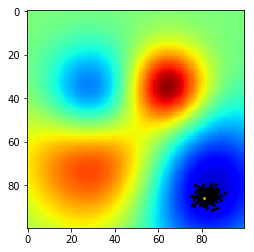

In [7]:
if __name__ == '__main__':
    pygmo_es()